In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# Transformaciones para el conjunto de entrenamiento
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(0.02),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor()
])

# Transformaciones para el conjunto de validación
val_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

# Cargando los datasets
train_dataset = datasets.ImageFolder('./chest_xray/train', transform=train_transforms)
val_dataset = datasets.ImageFolder('./chest_xray/val', transform=val_transforms)
test_dataset = datasets.ImageFolder('./chest_xray/test', transform=val_transforms)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [3]:
classes = train_dataset.classes
n_classes = len(classes)
print("Total classes:", n_classes)
print("Classes:", classes)

# También puedes verificar la distribución de las clases
from collections import Counter
train_counts = Counter([train_dataset.targets[i] for i in range(len(train_dataset))])
print("Distribution of classes in the training set:", train_counts)

Total classes: 2
Classes: ['NORMAL', 'PNEUMONIA']
Distribution of classes in the training set: Counter({1: 3875, 0: 1341})


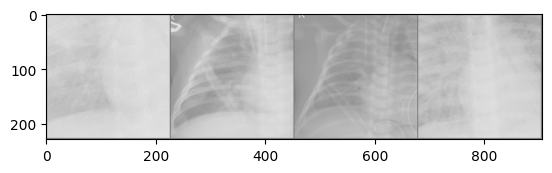

PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Función para mostrar una imagen
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Obtener algunas imágenes aleatorias del conjunto de entrenamiento
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Mostrar imágenes
imshow(torchvision.utils.make_grid(images[:4]))
# Mostrar etiquetas
print(' '.join(f'{classes[labels[j]]}' for j in range(4)))

In [5]:
def get_image_size(loader):
    for images, _ in loader:
        return images.size(2), images.size(3)

train_image_size = get_image_size(train_loader)
print("Tamaño de las imágenes en el conjunto de entrenamiento:", train_image_size)

Tamaño de las imágenes en el conjunto de entrenamiento: (224, 224)


In [6]:
def calculate_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += batch_samples
    mean /= total_images_count
    std /= total_images_count
    return mean, std

train_mean, train_std = calculate_mean_std(train_loader)
print("Media del conjunto de entrenamiento:", train_mean)
print("Desviación estándar del conjunto de entrenamiento:", train_std)

Media del conjunto de entrenamiento: tensor([0.5530, 0.5530, 0.5530])
Desviación estándar del conjunto de entrenamiento: tensor([0.1577, 0.1577, 0.1577])


In [7]:
# class SimpleCNN(nn.Module):
#     def __init__(self):
#         super(SimpleCNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 32, 3, stride=1, padding=0)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=0)
#         # ... más capas según sea necesario ...
#         self.fc1 = nn.Linear(64 * 54 * 54, 128)  # Ajustar según el tamaño de la entrada
#         self.fc2 = nn.Linear(128, 1)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         # ... más capas según sea necesario ...
#         x = x.view(-1, 64 * 54 * 54)  # Ajustar según el tamaño de la entrada
#         x = F.relu(self.fc1(x))
#         x = torch.sigmoid(self.fc2(x))
#         return x

# model = SimpleCNN()

In [8]:
# class SimpleCNN(nn.Module):
#     def __init__(self):
#         super(SimpleCNN, self).__init__()
#         # Capa de convolución 1
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=0)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

#         # Capa de convolución 2
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)

#         # Capa de convolución 3
#         self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0)

#         # Capa de convolución 4
#         self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0)

#         # Capa Fully Connected
#         self.fc1 = nn.Linear(128 * 12 * 12, 128)

#         # Capa de Dropout
#         self.dropout = nn.Dropout(0.2)

#         # Capa de salida
#         self.fc2 = nn.Linear(128, 1)

#     def forward(self, x):
#         # Aplicar las capas convolucionales y max pooling
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.conv3(x)))
#         x = self.pool(F.relu(self.conv4(x)))

#         # Aplanar las características para la capa fully connected
#         x = x.view(-1, 128 * 12 * 12)

#         # Aplicar la capa fully connected y dropout
#         x = F.relu(self.fc1(x))
#         x = self.dropout(x)

#         # Capa de salida
#         x = torch.sigmoid(self.fc2(x))
#         return x

# model = SimpleCNN()
# print(model)

In [9]:
def get_same_padding(kernel_size):
    pad = kernel_size // 2
    return pad

In [10]:
# class CustomCNN(nn.Module):
#     def __init__(self):
#         super(CustomCNN, self).__init__()
#         # Capa de convolución 1
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=get_same_padding(3))
#         self.bn1 = nn.BatchNorm2d(32)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=get_same_padding(2))

#         # Capa de convolución 2
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=get_same_padding(3))
#         self.bn2 = nn.BatchNorm2d(64)

#         # Capa de convolución 3
#         self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=get_same_padding(3))
#         self.bn3 = nn.BatchNorm2d(64)

#         # Capa de convolución 4
#         self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=get_same_padding(3))
#         self.bn4 = nn.BatchNorm2d(128)

#         # Calcula el tamaño correcto para la entrada de la capa fully connected
#         self.flat_features = self._get_conv_output((1, 3, 224, 224))

#         # Capa Fully Connected y Dropout
#         self.fc1 = nn.Linear(self.flat_features, 128)
#         self.dropout = nn.Dropout(0.2)
#         self.fc2 = nn.Linear(128, 1)

#     def _get_conv_output(self, shape):
#         with torch.no_grad():
#             input = torch.rand(*shape)
#             output = self._forward_features(input)
#             return int(np.prod(output.size()))

#     def _forward_features(self, x):
#         x = self.pool(F.relu(self.bn1(self.conv1(x))))
#         x = self.pool(F.relu(self.bn2(self.conv2(x))))
#         x = self.pool(F.relu(self.bn3(self.conv3(x))))
#         x = self.pool(F.relu(self.bn4(self.conv4(x))))
#         return x

#     def forward(self, x):
#         x = self._forward_features(x)
#         x = x.view(-1, self.flat_features)
#         x = F.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = torch.sigmoid(self.fc2(x))
#         return x

# model = CustomCNN()
# print(model)

In [11]:
import torchvision.models as models

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        # Utilizar ResNet18 como base
        resnet = models.resnet18(pretrained=True)
        self.base = nn.Sequential(*list(resnet.children())[:-2])  # Excluir las últimas dos capas de ResNet-18

        # Capa de convolución adicional (si es necesario)
        self.conv4 = nn.Conv2d(512, 128, kernel_size=3, stride=1, padding=1)  # Ajustar el número de canales según la salida de ResNet-18
        self.bn4 = nn.BatchNorm2d(128)

        # Calcula el tamaño correcto para la entrada de la capa fully connected
        self.flat_features = self._get_conv_output((1, 3, 224, 224))

        # Capa Fully Connected y Dropout
        self.fc1 = nn.Linear(self.flat_features, 128)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 1)

    def _get_conv_output(self, shape):
        with torch.no_grad():
            input = torch.rand(*shape)
            output = self._forward_features(input)
            return int(np.prod(output.size()))

    def _forward_features(self, x):
        x = self.base(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.adaptive_avg_pool2d(x, (1, 1))
        return x

    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(-1, self.flat_features)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

model = CustomCNN()
print(model)

/home/matcraft/anaconda3/envs/math/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/matcraft/anaconda3/envs/math/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/matcraft/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


CustomCNN(
  (base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)  # Optimiza solo la capa modificada
criterion = nn.BCELoss()# nn.BCEWithLogitsLoss()

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
model = model.to(device)

In [18]:
# Parámetros
num_epochs = 5

# Entrenamiento
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        # Mover datos al dispositivo
        inputs, labels = inputs.to(device), labels.to(device)

        # Limpiar gradientes
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        outputs = outputs.squeeze()

        # Convertir las etiquetas y las salidas a float si aún no lo son
        labels = labels.float()
        outputs = outputs.float()

        # Calcular la pérdida
        loss = criterion(outputs, labels)

        # Backward pass y optimización
        loss.backward()
        optimizer.step()

        # Acumular la pérdida del entrenamiento
        train_loss += loss.item() * inputs.size(0)

        # Calcular la precisión del entrenamiento
        predicted_train = outputs > 0.7  # Umbral
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    # Calcular pérdida y precisión promedio del entrenamiento
    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct_train / total_train

    # Validación
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            outputs = outputs.squeeze()

            # Convertir las etiquetas y las salidas a float si aún no lo son
            labels = labels.float()
            outputs = outputs.float()

            # Calcular la pérdida
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            # Calcular la precisión
            predicted = outputs > 0.7  # Umbral
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calcular pérdida y precisión promedio de validación
    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = 100 * correct / total

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%\n')

Epoch 1/5
Train Loss: 0.2091, Train Accuracy: 90.47%
Validation Loss: 0.3315, Validation Accuracy: 87.50%

Epoch 2/5
Train Loss: 0.1985, Train Accuracy: 91.18%
Validation Loss: 1.1613, Validation Accuracy: 68.75%

Epoch 3/5
Train Loss: 0.1925, Train Accuracy: 91.76%
Validation Loss: 0.2807, Validation Accuracy: 93.75%

Epoch 4/5
Train Loss: 0.1819, Train Accuracy: 92.52%
Validation Loss: 0.7429, Validation Accuracy: 62.50%

Epoch 5/5
Train Loss: 0.1752, Train Accuracy: 92.98%
Validation Loss: 0.8624, Validation Accuracy: 68.75%



In [19]:
# Colocar el modelo en modo de evaluación
model.eval()

# Listas para guardar las etiquetas verdaderas y las predicciones
true_labels = []
predictions = []

# No calcular gradientes
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Realizar predicciones
        outputs = model(inputs)
        outputs = outputs.squeeze()

        # Convertir las salidas a etiquetas predichas
        predicted_labels = (outputs > 0.7).float()  # Umbral ajustado si es necesario

        # Guardar las etiquetas y predicciones
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted_labels.cpu().numpy())

# Convertir listas a arrays de NumPy
true_labels = np.array(true_labels)
predictions = np.array(predictions)

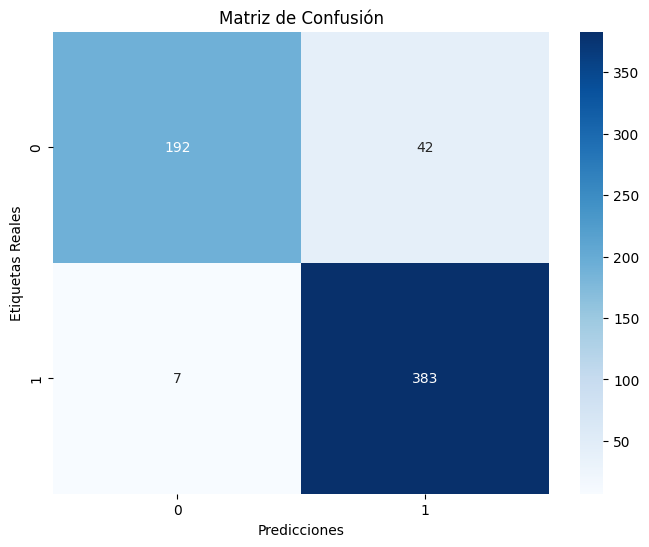

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predictions)

# Visualización de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Reales')
plt.title('Matriz de Confusión')
plt.show()